In [1]:
import numpy as np
from scipy import optimize
from scipy.special import expit

X = np.loadtxt('X.txt')
y = np.loadtxt('y.txt')

def evidence(X, y, var):
    b_map = get_b_map(X, y, var)
    X_tilde = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
    M = len(b_map)  # no. hyperparameters
    N = len(y)  # no. data points
    e = np.dot( y, np.log(expit(np.matmul(b_map,X_tilde.T))) )  +  np.dot( 1-y, np.log(1 - expit(np.matmul(b_map,X_tilde.T))) )
    e -= 0.5 * M * np.log(N)
    return e

def evidence_exact(X, y, var, b_map, ln_det_SN):
    X_tilde = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
    M = len(b_map)  # no. hyperparameters
    e = np.dot( y, np.log(expit(np.matmul(b_map,X_tilde.T))) )  +  np.dot( 1-y, np.log(1 - expit(np.matmul(b_map,X_tilde.T))) )
    e += -np.dot(b_map,b_map) / (2 * var) - 0.5 * M * np.log(2*np.pi * var)
    e += 0.5 * M * np.log(2*np.pi)
    e -= 0.5 * ln_det_SN
    return e
    
def log_likelihood_MAP(b, X_tilde, y):
    ll = np.dot( y, np.log(expit(np.matmul(b,X_tilde.T))) )  +  np.dot( 1-y, np.log(1 - expit(np.matmul(b,X_tilde.T))) )
    return ll

def log_likelihood_bayes(y, K_mu):
    ll = np.dot( y, np.log(expit(K_mu) ) ) +  np.dot( 1-y, np.log(1 - expit(K_mu) ) )
    return ll
                   
                   
def log_posterior(b, X_tilde, y, var):
    lp = -np.dot(b,b) / (2 * var)
    lp += np.dot( y, np.log(expit(np.matmul(b,X_tilde.T))) )  +  np.dot( 1-y, np.log(1 - expit(np.matmul(b,X_tilde.T))) )
    return lp

def gradient_log_posterior(b, X_tilde, y, var):
    gradient = -b / var + np.matmul( y - expit(np.matmul(b,X_tilde.T)) , X_tilde)
    return gradient 
    
def neg_log_posterior(b, X_tilde, y, var):
    return -log_posterior(b, X_tilde, y, var)

def neg_gradient_log_posterior(b, X_tilde, y, var):
    return -gradient_log_posterior(b, X_tilde, y, var)

In [2]:
def get_b_map(X,y,var):
    X_tilde = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
    b0 = np.ones(X_tilde.shape[1])
    b_map = optimize.fmin_l_bfgs_b(neg_log_posterior, b0, fprime=neg_gradient_log_posterior, args=(X_tilde,y,var))[0]
    return b_map

In [3]:
b_map = get_b_map(X, y, 1)
print(b_map)


[ 0.31278856 -0.10726085  0.80471152]


In [4]:
def log_evidence(X, y, b_map):
    X_tilde = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
    M = len(b_map)
    N = len(y)
    D = np.dot( y, np.log(expit(np.matmul(b_map,X_tilde.T))) )  +  np.dot( 1-y, np.log(1 - expit(np.matmul(b_map,X_tilde.T))) )
    print(D)
    D -= M/2 * np.log(N)
    
    return D

In [5]:
print(log_evidence(X, y, b_map))

-623.464621634
-633.826254552


In [6]:
def plot_data_internal(X, y):
    x_min, x_max = X[ :, 0 ].min() - .5, X[ :, 0 ].max() + .5
    y_min, y_max = X[ :, 1 ].min() - .5, X[ :, 1 ].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), \
        np.linspace(y_min, y_max, 100))
    plt.figure()
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    ax = plt.gca()
    ax.plot(X[y == 0, 0], X[y == 0, 1], 'ro', label = 'Class 1')
    ax.plot(X[y == 1, 0], X[y == 1, 1], 'bo', label = 'Class 2')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Plot data')
    plt.legend(loc = 'upper left', scatterpoints = 1, numpoints = 1)
    return xx, yy

##
# X: 2d array with the input features
# y: 1d array with the class labels (0 or 1)
#

def plot_data(X, y):
    xx, yy = plot_data_internal(X, y)
    plt.show()

##
# x: input to the logistic function
#

def logistic(x): return 1.0 / (1.0 + np.exp(-x))

##
# X: 2d array with the input features
# y: 1d array with the class labels (0 or 1)
# w: current parameter values
#

def compute_average_ll(X, y, w):
    output_prob = logistic(np.dot(X, w))
    return np.mean(y * np.log(output_prob) + (1 - y) * np.log(1.0 - output_prob))

##
# ll: 1d array with the average likelihood per data point and dimension equal
#     to the number of training epochs.
#


def plot_ll(ll):
    plt.figure()
    ax = plt.gca()
    plt.xlim(0, len(ll) + 2)
    plt.ylim(min(ll) - 0.1, max(ll) + 0.1)
    ax.plot(np.arange(1, len(ll) + 1), ll, 'r-')
    plt.xlabel('Steps')
    plt.ylabel('Average log-likelihood')
    plt.title('Plot Average Log-likelihood Curve')
    plt.show()

##
# x: 2d array with input features at which to compute predictions.
#
# (uses parameter vector w which is defined outside the function's scope)

def predict_for_plot(x):
    x_tilde = np.concatenate((np.ones((x.shape[0], 1)), x), 1)
    return logistic(np.dot(x_tilde, w))

##
# X: 2d array with the input features
# y: 1d array with the class labels (0 or 1)
# predict: function that recives as input a feature matrix and returns a 1d
#          vector with the probability of class 1.

def plot_predictive_distribution(X, y, predict):
    xx, yy = plot_data_internal(X, y)
    ax = plt.gca()  
    X_predict = np.concatenate((xx.ravel().reshape((-1, 1)), \
        yy.ravel().reshape((-1, 1))), 1)  # this gives 10000 x 2 array
    Z = predict(X_predict)
    Z = Z.reshape(xx.shape)
    cs2 = ax.contour(xx, yy, Z, cmap = 'RdBu', linewidths = 2)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 14)
    plt.show()

##
# l: hyper-parameter for the width of the Gaussian basis functions
# Z: location of the Gaussian basis functions
# X: points at which to evaluate the basis functions
# the radial basis functions are simply the Gaussian of a vector (the datapoint) - where l relates to the variance

def expand_inputs(l, X, Z):
    X2 = np.sum(X**2, 1)  # X**2, squares each of the elements of X, element-wise
    Z2 = np.sum(Z**2, 1)
    ones_Z = np.ones(Z.shape[ 0 ])  # create column of ones of same height as Z
    ones_X = np.ones(X.shape[ 0 ])
    r2 = np.outer(X2, ones_Z) - 2 * np.dot(X, Z.T) + np.outer(ones_X, Z2)
    return np.exp(-0.5 / l**2 * r2)

##
# x: 2d array with input features at which to compute the predictions
#    using the feature expansion
#
# (uses parameter vector w and the 2d array X with the centers of the basis
# functions for the feature expansion, which are defined outside the function's
# scope)
#

def predict_for_plot_expanded_features(x):
    x_expanded = expand_inputs(l, x, X)
    x_tilde = np.concatenate((np.ones((x_expanded.shape[ 0 ], 1 )), x_expanded), 1)
    return logistic(np.dot(x_tilde, w))

In [7]:
# create training and test data
X_training = X[0:800]
y_training = y[0:800]
X_test = X[800:]
y_test = y[800:]

MAP contour plot 

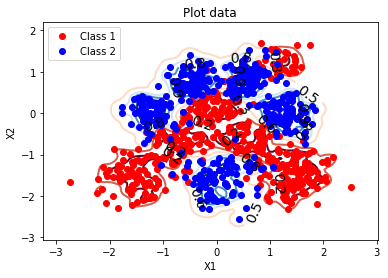

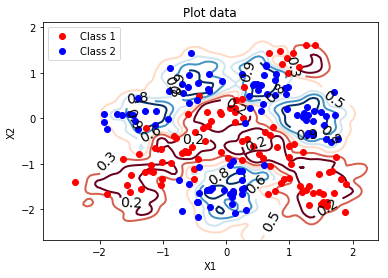

In [8]:
import matplotlib.pyplot as plt

# expand using radial basis functions - centred on training data

l = 0.1  # width of basis functions
var_0 = 1
X = X_training

# plot MAP contours for training data
X_RBF_training = expand_inputs(l, X_training, X)
w = get_b_map(X_RBF_training, y_training, var_0)
plot_predictive_distribution(X_training, y_training, predict_for_plot_expanded_features)

# plot MAP contours for test data
X_RBF_test = expand_inputs(l, X_test, X)
# w is that of expanded training data since w alone defines the contours 
plot_predictive_distribution(X_test, y_test, predict_for_plot_expanded_features)



Predictive contour plot

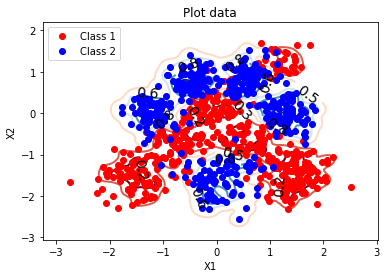

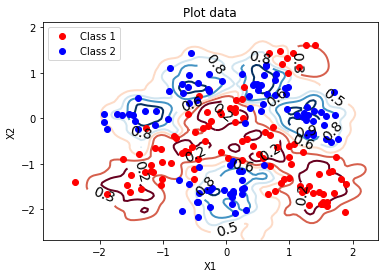

In [9]:

def laplace_parameters(X, var, mean):
    S0_inv = np.linalg.inv( var * np.identity(len(mean)) )
    X_tilde = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
    s = expit(np.matmul(mean,X_tilde.T))
    alpha = np.diag((1-s)*s)
    scaled_X_tilde = np.matmul(alpha, X_tilde)
    SN_inv = np.matmul( scaled_X_tilde.T, X_tilde) + S0_inv  # inverse covariance matrix of Gaussian
    SN = np.linalg.inv(SN_inv)
    
    return mean, SN


def bayesian_predictive_distribution(X, SN, mean):
    X_tilde = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
    var_a = np.array([np.matmul(x, np.matmul(SN, x.T)) for x in X_tilde])
    mean_a = np.matmul(mean, X_tilde.T)
    K_mu = mean_a / np.sqrt(1 + np.pi/8 * var_a)
    
    return K_mu 

def bayesian_predict_for_plot_expanded_features(x):
    x_expanded = expand_inputs(l, x, X)
    K_mu = bayesian_predictive_distribution(x_expanded, SN, mean)
    # SN and mean generated solely from training data
    # this ensures that expit(K_mu) (the predictive distribution, and hence the contours) is the same
    # when either training or test data is scatter plotted 
    return expit(K_mu)  # X, y and var are global variables

# expand using radial basis functions - centred on training data

l = 0.1  # width of basis functions
var_0 = 1
X = X_training
y = y_training

# plot full bayesian predictive contours for training data
X_RBF_training = expand_inputs(l, X_training, X)
mean = get_b_map(X_RBF_training, y_training, var_0)
mean, SN = laplace_parameters(X_RBF_training, var_0, mean)
plot_predictive_distribution(X_training, y_training, bayesian_predict_for_plot_expanded_features)

# plot full bayesian predictive contours for test data
X_RBF_test = expand_inputs(l, X_test, X)
# mean and SN are that of training data 
plot_predictive_distribution(X_test, y_test, bayesian_predict_for_plot_expanded_features)


MAP confusion matrices

In [10]:
def get_confusion(X, w, y):
    """ Obtains the confusion matrix given the data, X, and the optimum parameter, w.
    The confusion matrix indicates the proportion of false and true positives and negatives. """

    X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
    
    label = [1 if item > 0.5 else 0 for item in expit(np.dot(X, w))]

    confusion = np.array([[0, 0], [0, 0]])
    
    zeros = 0
    ones = 0
    
    for i in range(len(y)):
        if y[i] == 0:
            zeros += 1 
            if label[i] == 0:
                confusion[0, 0] += 1
            else:
                confusion[0, 1] += 1
        else:
            ones += 1
            if label[i] == 0:
                confusion[1, 0] += 1
            else:
                confusion[1, 1] += 1
    
    confusion = np.array([confusion[0,:]/zeros, confusion[1,:]/ones])
    
    return confusion


def get_confusion_predictive(K_mu, y):
    """ Obtains the confusion matrix given the data, X, and the optimum parameter, w.
    The confusion matrix indicates the proportion of false and true positives and negatives. """
    
    label = [1 if item > 0.5 else 0 for item in expit(K_mu)]

    confusion = np.array([[0, 0], [0, 0]])

    zeros = 0
    ones = 0
    
    for i in range(len(y)):
        if y[i] == 0:
            zeros += 1 
            if label[i] == 0:
                confusion[0, 0] += 1
            else:
                confusion[0, 1] += 1
        else:
            ones += 1
            if label[i] == 0:
                confusion[1, 0] += 1
            else:
                confusion[1, 1] += 1
    
    confusion = np.array([confusion[0,:]/zeros, confusion[1,:]/ones])
    
    return confusion

print("training")
b_map = get_b_map(X_RBF_training, y_training, var_0)
confusion_MAP = get_confusion(X_RBF_training, b_map, y_training)
print("MAP Confusion:", confusion_MAP)

K_mu = bayesian_predictive_distribution(X_RBF_training, SN, mean)
confusion_predictive = get_confusion_predictive(K_mu, y_training)
print("Predictive Confusion:", confusion_predictive)

print("\ntest")
# b_map is the same 
confusion_MAP = get_confusion(X_RBF_test, b_map, y_test)
print("MAP Confusion:", confusion_MAP)

K_mu = bayesian_predictive_distribution(X_RBF_test, SN, mean)
confusion_predictive = get_confusion_predictive(K_mu, y_test)
print("Predictive Confusion:", confusion_predictive)

training
MAP Confusion: [[ 0.94567901  0.05432099]
 [ 0.05316456  0.94683544]]
Predictive Confusion: [[ 0.94567901  0.05432099]
 [ 0.05316456  0.94683544]]

test
MAP Confusion: [[ 0.91089109  0.08910891]
 [ 0.14141414  0.85858586]]
Predictive Confusion: [[ 0.91089109  0.08910891]
 [ 0.14141414  0.85858586]]


In [11]:
# ll for test data - MAP
X_RBF_training_tilde = np.concatenate((np.ones((X_RBF_training.shape[0], 1)), X_RBF_training), 1)
training_map_ll = log_likelihood_MAP(b_map, X_RBF_training_tilde, y_training)
N = len(y_training)
print(training_map_ll/N)

# ll for training data - MAP
X_RBF_test_tilde = np.concatenate((np.ones((X_RBF_test.shape[0], 1)), X_RBF_test), 1)
test_map_ll = log_likelihood_MAP(b_map, X_RBF_test_tilde, y_test)
N = len(y_test)
print(test_map_ll/N)

# ll for test data - full Bayesian
K_mu = bayesian_predictive_distribution(X_RBF_training, SN, mean)
training_bayes_ll = log_likelihood_bayes(y_training, K_mu)
N = len(y_training)
print(training_bayes_ll/N)

# ll for training data - full Bayesian
K_mu = bayesian_predictive_distribution(X_RBF_test, SN, mean)
test_bayes_ll = log_likelihood_bayes(y_test, K_mu)
N = len(y_test)
print(test_bayes_ll/N)


-0.216592187118
-0.324270719403
-0.255957826291
-0.348189547036


In [12]:
l = 0.1  # width of basis functions
var_0 = 1
X = X_training
X_RBF_training = expand_inputs(l, X_training, X)

e = evidence(X_RBF_training, y_training, var_0)
print("Evidence:", e)

Evidence: -2850.46074663


In [13]:
l = 0.1  # width of basis functions
var_0 = 1
X = X_training
X_RBF_training = expand_inputs(l, X_training, X)

b_map = get_b_map(X_RBF_training, y_training, var_0)
_, SN = laplace_parameters(X_RBF_training, var_0, b_map)
L = np.linalg.cholesky(SN)  # cholesky decomposition of SN
ln_det_SN = 2 * np.sum(np.log(np.diag(L)))  # log turns product into sum -> det(sN) = det(L)^2
e = evidence_exact(X_RBF_training, y_training, var_0, b_map, ln_det_SN)

print("Exact Evidence:", e)

Exact Evidence: -161.136133831


In [14]:
var_range = np.exp(np.linspace(-2,2,10))
l_range = np.exp(np.linspace(-2,2,10))

X = X_training

for l in l_range:
    for var_0 in var_range:
        X_RBF_training = expand_inputs(l, X_training, X)
        b_map = get_b_map(X_RBF_training, y_training, var_0)
        _,SN = laplace_parameters(X_RBF_training, var_0, b_map)
        L = np.linalg.cholesky(SN)  # cholesky decomposition of SN
        ln_det_SN = 2 * np.sum(np.log(np.diag(L)))  # log turns product into sum -> det(sN) = det(L)^2
        e = evidence_exact(X_RBF_training, y_training, var_0, b_map, ln_det_SN)
        
        print("Exact Evidence:", e, "l:", l, "var:", var_0)

Exact Evidence: 1314.95882699 l: 0.135335283237 var: 0.135335283237
Exact Evidence: 997.964619503 l: 0.135335283237 var: 0.211072087791
Exact Evidence: 679.636924964 l: 0.135335283237 var: 0.329192987808
Exact Evidence: 359.623176751 l: 0.135335283237 var: 0.513417119033
Exact Evidence: 37.855361148 l: 0.135335283237 var: 0.800737402917
Exact Evidence: -285.564315548 l: 0.135335283237 var: 1.248848869
Exact Evidence: -610.476977476 l: 0.135335283237 var: 1.94773404105
Exact Evidence: -936.736022562 l: 0.135335283237 var: 3.03773177752
Exact Evidence: -1264.23055851 l: 0.135335283237 var: 4.73771785964
Exact Evidence: -1592.85835953 l: 0.135335283237 var: 7.38905609893


C:\Users\clint\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log


Exact Evidence: 1400.93845787 l: 0.211072087791 var: 0.135335283237
Exact Evidence: 1071.39328924 l: 0.211072087791 var: 0.211072087791
Exact Evidence: 739.500062122 l: 0.211072087791 var: 0.329192987808
Exact Evidence: 405.735164628 l: 0.211072087791 var: 0.513417119033
Exact Evidence: 70.5611836261 l: 0.211072087791 var: 0.800737402917
Exact Evidence: -265.637460615 l: 0.211072087791 var: 1.248848869
Exact Evidence: -602.577064231 l: 0.211072087791 var: 1.94773404105
Exact Evidence: -940.066407762 l: 0.211072087791 var: 3.03773177752
Exact Evidence: -1277.97332265 l: 0.211072087791 var: 4.73771785964
Exact Evidence: -1616.19622559 l: 0.211072087791 var: 7.38905609893
Exact Evidence: 1442.06871558 l: 0.329192987808 var: 0.135335283237
Exact Evidence: 1102.23287269 l: 0.329192987808 var: 0.211072087791
Exact Evidence: 760.57417536 l: 0.329192987808 var: 0.329192987808
Exact Evidence: 417.661950359 l: 0.329192987808 var: 0.513417119033
Exact Evidence: 73.9894221035 l: 0.329192987808 var

In [20]:
var_range = np.exp(np.linspace(-4,4,10))
l_range = np.exp(np.linspace(-4,4,10))
ev = np.zeros((len(var_range), len(l_range)))

X = X_training
i = 0
j = 0

for l in l_range:
    i=0
    for var_0 in var_range:
        X_RBF_training = expand_inputs(l, X_training, X)
        e = evidence(X_RBF_training, y_training, var_0)
        ev[j,i] = e
        i+=1
        print("Approx. Evidence:", e, "var:", var_0, "l:", l, )
    j+=1
    
print(ev)

Approx. Evidence: -3226.68164507 var: 0.0183156388887 l: 0.0183156388887
Approx. Evidence: -3219.79218215 var: 0.0445514262445 l: 0.0183156388887
Approx. Evidence: -3204.04053839 var: 0.108368023222 l: 0.0183156388887
Approx. Evidence: -3170.54916547 var: 0.263597138116 l: 0.0183156388887
Approx. Evidence: -3108.19041043 var: 0.64118038843 l: 0.0183156388887
Approx. Evidence: -3014.05232818 var: 1.55962349761 l: 0.0183156388887
Approx. Evidence: -2907.16752469 var: 3.79366789468 l: 0.0183156388887
Approx. Evidence: -2816.87921969 var: 9.22781435214 l: 0.0183156388887
Approx. Evidence: -2755.75432616 var: 22.4459705176 l: 0.0183156388887
Approx. Evidence: -2719.46586267 var: 54.5981500331 l: 0.0183156388887
Approx. Evidence: -3218.7122194 var: 0.0183156388887 l: 0.0445514262445
Approx. Evidence: -3201.97587073 var: 0.0445514262445 l: 0.0445514262445
Approx. Evidence: -3167.97193523 var: 0.108368023222 l: 0.0445514262445
Approx. Evidence: -3109.14900855 var: 0.263597138116 l: 0.044551426

C:\Users\clint\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log


Approx. Evidence: -2918.99836277 var: 0.0183156388887 l: 0.263597138116
Approx. Evidence: -2873.60286348 var: 0.0445514262445 l: 0.263597138116
Approx. Evidence: -2845.03134902 var: 0.108368023222 l: 0.263597138116
Approx. Evidence: -2827.06020629 var: 0.263597138116 l: 0.263597138116
Approx. Evidence: -2814.39145753 var: 0.64118038843 l: 0.263597138116
Approx. Evidence: -2804.27069723 var: 1.55962349761 l: 0.263597138116
Approx. Evidence: -2795.8029844 var: 3.79366789468 l: 0.263597138116
Approx. Evidence: -2788.55202075 var: 9.22781435214 l: 0.263597138116
Approx. Evidence: -2781.91189773 var: 22.4459705176 l: 0.263597138116
Approx. Evidence: -2775.23968473 var: 54.5981500331 l: 0.263597138116
Approx. Evidence: -2885.71143492 var: 0.0183156388887 l: 0.64118038843
Approx. Evidence: -2856.5595207 var: 0.0445514262445 l: 0.64118038843
Approx. Evidence: -2839.9135244 var: 0.108368023222 l: 0.64118038843
Approx. Evidence: -2830.7568135 var: 0.263597138116 l: 0.64118038843
Approx. Evidence

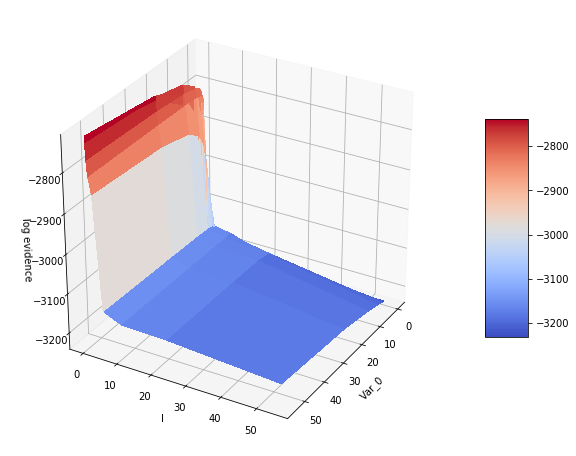

In [73]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

var_array_mesh, l_array_mesh = np.meshgrid(var_range,l_range)


fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(var_array_mesh, l_array_mesh, ev, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
#ax.set_zlim(-1.0, 0.5)
#xlabel('x')
ax.set_xlabel('Var_0')
ax.set_ylabel('l')
ax.set_zlabel('log evidence')
#ylabel('y')
ax.view_init(elev=30., azim=30)
fig.colorbar(surf, shrink=0.5, aspect=5)



plt.show()

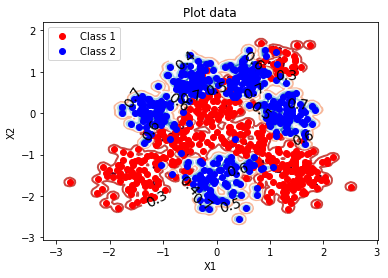

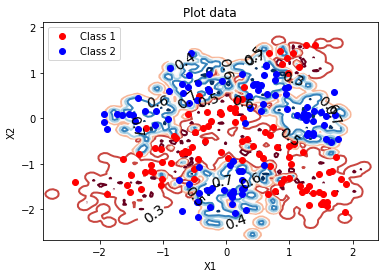

In [74]:
l = 0.05  # width of basis functions
var_0 = 100

def laplace_parameters(X, var, mean):
    S0_inv = np.linalg.inv( var * np.identity(len(mean)) )
    X_tilde = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
    s = expit(np.matmul(mean,X_tilde.T))
    alpha = np.diag((1-s)*s)
    scaled_X_tilde = np.matmul(alpha, X_tilde)
    SN_inv = np.matmul( scaled_X_tilde.T, X_tilde) + S0_inv  # inverse covariance matrix of Gaussian
    SN = np.linalg.inv(SN_inv)
    
    return mean, SN


def bayesian_predictive_distribution(X, SN, mean):
    X_tilde = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
    var_a = np.array([np.matmul(x, np.matmul(SN, x.T)) for x in X_tilde])
    mean_a = np.matmul(mean, X_tilde.T)
    K_mu = mean_a / np.sqrt(1 + np.pi/8 * var_a)
    
    return K_mu 

def bayesian_predict_for_plot_expanded_features(x):
    x_expanded = expand_inputs(l, x, X)
    K_mu = bayesian_predictive_distribution(x_expanded, SN, mean)
    # SN and mean generated solely from training data
    # this ensures that expit(K_mu) (the predictive distribution, and hence the contours) is the same
    # when either training or test data is scatter plotted 
    return expit(K_mu)  # X, y and var are global variables

# expand using radial basis functions - centred on training data

X = X_training
y = y_training

# plot full bayesian predictive contours for training data
X_RBF_training = expand_inputs(l, X_training, X)
mean = get_b_map(X_RBF_training, y_training, var_0)
mean, SN = laplace_parameters(X_RBF_training, var_0, mean)
plot_predictive_distribution(X_training, y_training, bayesian_predict_for_plot_expanded_features)

# plot full bayesian predictive contours for test data
X_RBF_test = expand_inputs(l, X_test, X)
# mean and SN are that of training data 
plot_predictive_distribution(X_test, y_test, bayesian_predict_for_plot_expanded_features)
